#Задание 5. Анализ текстовых данных средствами BERT и LSTM (Assessment 5. Text Data Analysis with BERT and LSTM)

#Анализ текстовых данных средствами BERT и стека LSTM

**Цель работы** – получить навыки обучения и использования архитектур BERT, стека LSTM и двунаправленной LSTM для задач классификации текстовых данных.

**Задачи** – Обучить нейросетевые модели BERT, стека LSTM, двунаправленную LSTM, предсказывающие авторство текстов по фрагменту текстов.


https://docs.google.com/spreadsheets/d/1dyB9C8XX3SNYw7e6jZvd5bXCDXIEKHMunrcKmhZn7kE/edit?usp=sharing

https://colab.research.google.com/drive/1h-eBBAVnOu11_OsU7TjtIsyz0MCZbfmQ?usp=sharing



#Импорт библиотек


In [116]:
!pip install transformers

In [117]:
import pandas as pd
import os
import csv
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data Collection & Preparation

## Data source

In [118]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Ganti dengan path file CSV Anda
file_path = '/content/drive/My Drive/russian_poetry_data.csv'

df = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
# Tampilkan 5 baris pertama DataFrame
# print(df.head())
df

,author,title,fragment
0,Лермонтов М.Ю.,А. О. Смирновой,В простосердечии невежды\nКороче знать вас я ж...
1,Лермонтов М.Ю.,Ангел,По небу полуночи ангел летел\r\nИ тихую песню ...
2,Лермонтов М.Ю.,К Нине,Ах! сокрылась в мрак ненастный\r\nСчастья прош...
3,Лермонтов М.Ю.,Баллада,"Куда так проворно, жидовка младая?\r\nЧас утра..."
4,Лермонтов М.Ю.,Парус,Белеет парус одинокой\nВ тумане моря голубом!....
...,...,...,...
107,Тютчев Ф.И.,Снежные горы,"Уже полдневная пора\r\nПалит отвесными лучами,..."
108,Тютчев Ф.И.,К. Б.,Я встретил вас — и всё былое\r\nВ отжившем сер...
109,Тютчев Ф.И.,empty,"Певучесть есть в морских волнах,\r\nГармония в..."
110,Тютчев Ф.И.,empty,"Тихой ночью, поздним летом,\r\nКа́к на небе зв..."


In [120]:
df.describe()

,author,title,fragment
count,112,112,112
unique,4,107,112
top,Лермонтов М.Ю.,empty,В простосердечии невежды\nКороче знать вас я ж...
freq,28,4,1


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   author    112 non-null    object
 1   title     112 non-null    object
 2   fragment  112 non-null    object
dtypes: object(3)
memory usage: 2.8+ KB


# Data Preprocessing

In [122]:
data_raw = df
# Step 1: Load the CSV File
def load_data(filename=data_raw):
    data = pd.read_csv(filename)
    print(f"Data loaded successfully! Total records: {len(data)}")
    return data

# Step 2: Preprocess the Text
def preprocess_text(text):
    # Basic cleaning: Remove extra spaces and special characters
    text = text.strip()  # Remove leading/trailing spaces
    text = text.replace("\n", " ")  # Replace newlines with space
    return text

# Step 3: Split the Data - function yg ada dibawah ini khusus untuk data yg besar
def split_data(data, test_size=0.2, val_size=0.1):
    # Preprocess text
    data["fragment"] = data["fragment"].apply(preprocess_text)

    # Split into training + validation and test sets
    train_val, test = train_test_split(data, test_size=test_size, stratify=data["author"], random_state=42)

    # Split training + validation into separate training and validation sets
    val_ratio = val_size / (1 - test_size)  # Adjust validation ratio
    train, val = train_test_split(train_val, test_size=val_ratio, stratify=train_val["author"], random_state=42)

    print(f"Data split completed:")
    print(f" - Training set: {len(train)} samples")
    print(f" - Validation set: {len(val)} samples")
    print(f" - Test set: {len(test)} samples")

    return train, val, test

- def load_data(filename=data_raw):: Эта строка определяет функцию с именем load_data. Она принимает один аргумент, filename, который по умолчанию равен data_raw, если не указан.
- data = pd.read_csv(filename): Эта строка использует функцию pd.read_csv из библиотеки pandas для чтения CSV-файла, указанного в filename, и сохраняет его в DataFrame с именем data.
- print(f"Data loaded successfully! Total records: {len(data)}"): Эта строка выводит сообщение, указывающее на успешную загрузку данных, и отображает общее количество записей в DataFrame.

- def preprocess_text(text):: Эта строка определяет функцию с именем preprocess_text. Она принимает один аргумент, text, который представляет текст для предварительной обработки.
- text = text.strip(): Эта строка удаляет начальные и конечные пробелы из text.
- text = text.replace("\n", " "): Эта строка заменяет символы новой строки (\n) пробелами.
- return text: Эта строка возвращает предварительно обработанный текст.

- def split_data(data, test_size=0.2, val_size=0.1):: Эта строка определяет функцию с именем split_data. Она принимает три аргумента: data для разделения, test_size (по умолчанию 0,2 или 20%) и val_size (по умолчанию 0,1 или 10%).
- data["fragment"] = data["fragment"].apply(preprocess_text): Эта строка применяет функцию preprocess_text к столбцу 'fragment' DataFrame, вероятно содержащему текстовые данные.
- train_val, test = train_test_split(...): Эта строка использует train_test_split из sklearn для разделения данных на два набора: train_val (для обучения и валидации) и test. Параметр stratify гарантирует, что разделения имеют аналогичное распределение значений author. random_state гарантирует воспроизводимость разделения.
- train, val = train_test_split(...): Эта строка дополнительно разделяет train_val на наборы train и val, используя аналогичную логику.
- print(...): Этот блок выводит информацию о размерах созданных наборов данных.
- return train, val, test: Эта строка возвращает три созданных DataFrame: train, val и test.

### Check for each step

In [123]:
train, val, test= split_data(data_raw)

# save the splits for later use
train.to_csv('train.csv', index=False, encoding='utf-8')
val.to_csv('val.csv', index=False, encoding='utf-8')
test.to_csv('test.csv', index=False, encoding='utf-8')

print('Trian, validation, and test sets saved successfully!')

Data split completed:
 - Training set: 77 samples
 - Validation set: 12 samples
 - Test set: 23 samples
Trian, validation, and test sets saved successfully!


# Tokenization & text Vectorization

In [124]:
# step 1: load the pre-trained tokenizer
def load_tokenizer():
  # using BERT method
    tokenizer= BertTokenizer.from_pretrained('bert-base-multilingual-cased')
    print('Tokenizer loaded successfully!\n')
    return tokenizer

# step 2: tokenize the text data
def tokenize_text(data, tokenize, max_length=128):
    # tokenize and pad/truncate sequences to max_length
    inputs= tokenize(
        list(data['fragment']),
        padding='max_length' ,
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )
    print(f"Tokenization completed! Tokens shape: {inputs['input_ids'].shape}")
    return inputs

# Convert tokenized inputs to tensorflow dataset
def create_tf_dataset(tokenized_inputs):
    dataset= tf.data.Dataset.from_tensor_slices({
        'input_ids': tokenized_inputs['input_ids'],
        'attention_mask': tokenized_inputs['attention_mask'],
        'token_type_ids': tokenized_inputs['token_type_ids'],
        })
    print('Converted to TensorFlow Dataset successfully!\n')
    return dataset

# save tensorflow dataset
def save_tf_dataset(dataset, directory):
    # ensure the directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)
    # save datasete to disk
    tf.data.experimental.save(dataset, directory)
    print(f'Dataset saved to {directory} \n')


- def load_tokenizer():: Эта строка определяет функцию с именем load_tokenizer, которая будет отвечать за загрузку предварительно обученного токенизатора.
- tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased'): Это ядро функции.
  - Она использует класс BertTokenizer из библиотеки transformers.
  - from_pretrained('bert-base-multilingual-cased') загружает предварительно обученный токенизатор под названием "bert-base-multilingual-cased". Этот конкретный токенизатор предназначен для работы с текстом на нескольких языках и чувствителен к регистру (то есть он различает прописные и строчные буквы).
- print('Tokenizer loaded successfully!\n'): Эта строка просто выводит сообщение на консоль, подтверждая, что токенизатор был загружен.
- return tokenizer: Функция возвращает загруженный объект tokenizer, делая его доступным для использования в других частях кода.


- def tokenize_text(data, tokenize, max_length=128):: Это определяет функцию с именем tokenize_text, которая принимает данные для токенизации, функцию токенизатора и максимальную длину последовательностей в качестве входных данных.
- inputs = tokenize(...): Эта строка применяет функцию tokenize (которая будет объектом tokenizer, загруженным на предыдущем шаге) к текстовым данным.
  - list(data['fragment']): Это извлекает текстовое содержимое из столбца с именем 'fragment' в данных и преобразует его в список. Это текст, который будет токенизирован.
  - padding='max_length': Гарантирует, что все последовательности имеют одинаковую длину, добавляя токены заполнения к более коротким последовательностям.
  - truncation=True: Обрезает последовательности длиннее max_length до указанной максимальной длины.
  - max_length=max_length: Устанавливает максимальную длину последовательности (по умолчанию 128 токенов).
  - return_tensors='tf': Указывает, что выходные данные должны быть тензорами TensorFlow, которые являются структурами данных, используемыми TensorFlow.
- print(f"Tokenization completed! Tokens shape: {inputs['input_ids'].shape}"): Выводит сообщение подтверждения и форму токенизированных идентификаторов ввода.
- return inputs: Функция возвращает токенизированные входные данные, которые включают 'input_ids', 'attention_mask' и 'token_type_ids'. Они необходимы для моделей BERT.

- def create_tf_dataset(tokenized_inputs):: Это определяет функцию, которая принимает токенизированные входные данные из предыдущего шага и создает набор данных TensorFlow.
- dataset = tf.data.Dataset.from_tensor_slices(...): Это создает объект набора данных TensorFlow.
  - from_tensor_slices используется для создания набора данных из токенизированных входных данных, которые по сути являются фрагментами тензоров (многомерных массивов).
- print('Converted to TensorFlow Dataset successfully!\n'): Выводит сообщение подтверждения.
- return dataset: Возвращает созданный набор данных TensorFlow.

- def save_tf_dataset(dataset, directory):: Это определяет функцию для сохранения набора данных TensorFlow в указанный каталог.
- if not os.path.exists(directory): os.makedirs(directory): Это гарантирует, что целевой каталог существует; если нет, он создается.
- tf.data.experimental.save(dataset, directory): Эта строка сохраняет dataset в заданный directory.

###Check each step

In [125]:
# load data
train_data= pd.read_csv('train.csv')
val_data= pd.read_csv('val.csv')
test_data= pd.read_csv('test.csv')

# load tokenizer
tokenizer= load_tokenizer()

# tokenize text
max_length= 128
train_inputs= tokenize_text(train_data, tokenizer, max_length)
val_inputs= tokenize_text(val_data, tokenizer,max_length)
test_inputs= tokenize_text(test_data, tokenizer, max_length)

# convert tokenized inputs to tensorflow datasets
train_dataset= create_tf_dataset(train_inputs)
val_dataset= create_tf_dataset(val_inputs)
test_dataset= create_tf_dataset(test_inputs)

# save tensorflow
save_tf_dataset(train_dataset, 'train_dataset')
save_tf_dataset(val_dataset, 'val_dataset')
save_tf_dataset(test_dataset, 'test_dataset')

print('Tokenized inputs saved successfully!')

Tokenizer loaded successfully!

Tokenization completed! Tokens shape: (77, 128)
Tokenization completed! Tokens shape: (12, 128)
Tokenization completed! Tokens shape: (23, 128)
Converted to TensorFlow Dataset successfully!

Converted to TensorFlow Dataset successfully!

Converted to TensorFlow Dataset successfully!

Dataset saved to train_dataset 

Dataset saved to val_dataset 

Dataset saved to test_dataset 

Tokenized inputs saved successfully!


# ====================================================

# Model building & Training

## BERT Model

In [130]:
def build_bert_model(pretrained_model_name='bert-base-multilingual-cased', max_length=128, num_classes=2):
    """
    Builds a fine-tuned BERT model for text classification.
    Args:
        pretrained_model_name (str): Name of the pre-trained BERT model.
        max_length (int): Maximum sequence length.
        num_classes (int): Number of output classes.
    Returns:
        tf.keras.Model: Compiled BERT-based model.
    """
    # Load pre-trained BERT model
    bert_model = TFBertModel.from_pretrained(pretrained_model_name)

    # Input layers
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

    # BERT outputs
    outputs = tf.keras.layers.Lambda(
        lambda x: bert_model(x[0], attention_mask=x[1]),
        output_shape=(max_length, bert_model.config.hidden_size) # Changed to a tuple
    )([input_ids, attention_mask])
    pooled_output = outputs[1]  # Access the pooled output (second element)

    # Classification layers
    dropout = tf.keras.layers.Dropout(0.3)(pooled_output)
    output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout)

    # Define the model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output_layer)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

- def build_bert_model(...): Эта строка определяет функцию с именем build_bert_model.
- pretrained_model_name='bert-base-multilingual-cased': Здесь устанавливается используемая по умолчанию предварительно обученная модель BERT. 'bert-base-multilingual-cased' - это модель BERT, обученная на многих языках и чувствительная к регистру.
- max_length=128: Здесь устанавливается максимальная длина текстовых последовательностей, которые модель будет обрабатывать (128 токенов).
- num_classes=2: Это количество выходных классов для задачи классификации по умолчанию (например, положительный/отрицательный настрой).

- Загрузка предварительно обученной модели BERT
  - TFBertModel.from_pretrained(...): Эта строка загружает указанную предварительно обученную модель BERT с помощью библиотеки transformers. Эта модель будет основой для нашего классификатора текста.

- tf.keras.layers.Input(...): Эти строки создают два входных слоя для модели:
  - input_ids: Этот слой будет получать идентификаторы токенов входного текста.
  - attention_mask: Этот слой будет указывать, на какие токены во входной последовательности следует обращать внимание

- tf.keras.layers.Lambda(...): Эта строка создает пользовательский слой для применения модели BERT к входным данным. Она использует лямбда-функцию для передачи input_ids и attention_mask модели BERT.
- pooled_output = outputs[1]: Здесь извлекается объединенный вывод из выводов модели BERT, который представляет собой сжатое представление всей входной последовательности.

- tf.keras.layers.Dropout(0.3): Это добавляет слой отсева, чтобы предотвратить переобучение. Он случайным образом устанавливает 30% входных единиц в 0 во время обучения.
- tf.keras.layers.Dense(num_classes, activation='softmax'): Это добавляет плотный (полносвязный) слой с num_classes выходными единицами и функцией активации softmax. Этот слой выдает окончательные вероятности классификации.

- tf.keras.Model(...): Эта строка создает общую модель Keras, указывая входные и выходные данные.
- model.compile(...): Это компилирует модель, настраивая ее для обучения:
  - optimizer: Для обучения используется оптимизатор Adam.
  - loss: 'sparse_categorical_crossentropy' - это функция потерь, подходящая для многоклассовой классификации.
  - metrics: 'accuracy' используется для оценки производительности модели.



### Train the BERT

In [131]:
# Train the model BERT
num_epochs = 10

# Assuming 'author' is the target column in DataFrame
# and train_data, val_data are DataFrames
train_labels = train_data['author'].factorize()[0] # Convert author names to numerical labels
val_labels = val_data['author'].factorize()[0]   # Convert author names to numerical labels

# Update train_dataset and val_dataset to include labels
train_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': train_inputs['input_ids'],
    'attention_mask': train_inputs['attention_mask']
}, train_labels))  # Include labels in the dataset

val_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': val_inputs['input_ids'],
    'attention_mask': val_inputs['attention_mask']
}, val_labels))  # Include labels in the dataset

# Call build_bert_model to create the model instance
model_bert = build_bert_model(num_classes=len(train_data['author'].unique())) # Pass num_classes

# Now call model.fit with the updated datasets
history = model_bert.fit(
    train_dataset.batch(32),  #32
    validation_data=val_dataset.batch(32), #32
    epochs=num_epochs
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 104s 15s/step - accuracy: 0.2887 - loss: 1.3709 - val_accuracy: 0.2500 - val_loss: 1.4498
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 12s/step - accuracy: 0.2562 - loss: 1.4374 - val_accuracy: 0.2500 - val_loss: 1.4488
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 43s 13s/step - accuracy: 0.3134 - loss: 1.4392 - val_accuracy: 0.2500 - val_loss: 1.4480
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 15s/step - accuracy: 0.2874 - loss: 1.4277 - val_accuracy: 0.2500 - val_loss: 1.4471
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 41s 12s/step - accuracy: 0.2536 - loss: 1.4388 - val_accuracy: 0.2500 - val_loss: 1.4463
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 40s 13s/step - accuracy: 0.1859 - loss: 1.5132 - val_accuracy: 0.2500 - val_loss: 1.4455
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step - accuracy: 0.2757 - loss: 1.4851 - val_accuracy: 0.2500 - val_loss: 1.4447
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 40s 13s/step - accuracy: 0.2406 - loss: 1.5048 - val_accuracy: 0.2500 - val_loss: 1.4440

### Model saved bert_text_classifier.keras

In [132]:
# Save the model using the TensorFlow SavedModel format
model_bert.save('bert_text_classifier.keras')  # Add .keras extension for the native Keras format
print("\nModel training complete and saved using SavedModel format!")


Model training complete and saved using SavedModel format!


In [133]:
test_labels = test_data['author'].factorize()[0] # Convert author names to numerical labels


# Update test_dataset to include labels
test_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': test_inputs['input_ids'],
    'attention_mask': test_inputs['attention_mask']
}, test_labels))  # Include labels in the dataset


loss, accuracy = model_bert.evaluate(test_dataset.batch(32)) # Asumsikan nama dataset test 'test_dataset'

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.2609 - loss: 1.4542
Test Loss: 1.4541782140731812
Test Accuracy: 0.260869562625885


## Data Visualization

In [25]:

# Evaluasi model pada data test
test_labels = test_data['author'].factorize()[0]  # Convert author names to numerical labels

# Update test_dataset to include labels
test_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': test_inputs['input_ids'],
    'attention_mask': test_inputs['attention_mask']
}, test_labels))  # Include labels in the dataset

loss, accuracy = model_bert.evaluate(test_dataset.batch(32))
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# 1. Generate predictions for classification report and confusion matrix
y_true = []
y_pred = []
for batch in test_dataset.batch(32):  # Use the same batch size as during evaluation
    inputs, labels = batch
    predictions = model_bert.predict(inputs)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))  # Get predicted class labels

# 2. Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_data['author'].unique()))


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.2857 - loss: 1.4105
Test Loss: 1.4104853868484497
Test Accuracy: 0.2857142984867096
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step

Classification Report:
                precision    recall  f1-score   support

 Некрасов Н.А.       0.00      0.00      0.00         5
   Тютчев Ф.И.       0.00      0.00      0.00         5
Лермонтов М.Ю.       0.29      1.00      0.44         6
   Есенин С.А.       0.00      0.00      0.00         5

      accuracy                           0.29        21
     macro avg       0.07      0.25      0.11        21
  weighted avg       0.08      0.29      0.13        21



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Confusion matrix

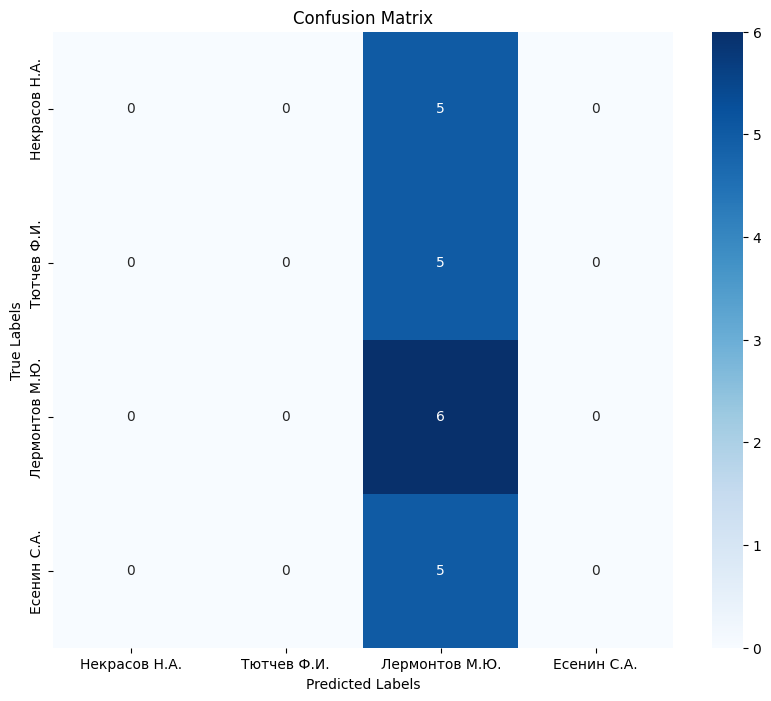

In [26]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_data['author'].unique(),
            yticklabels=train_data['author'].unique())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


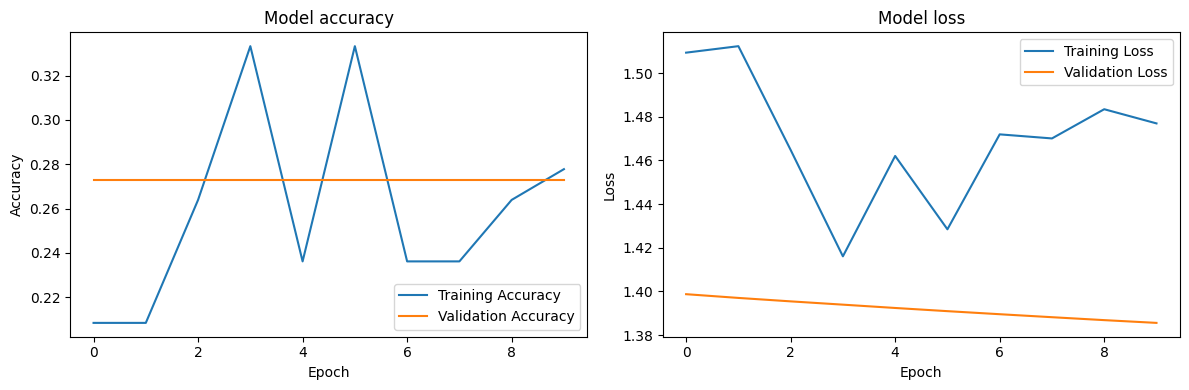

In [27]:
# 4. Akurasi dan Loss selama training (jika history tersedia)
if history:  # Check if history object is available
    plt.figure(figsize=(12, 4))

    # Plot Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.tight_layout()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

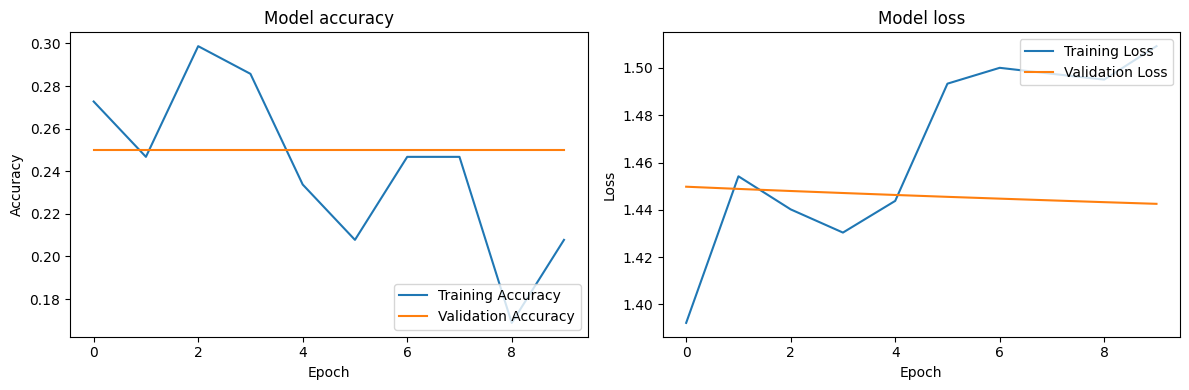

In [134]:
# 4. Akurasi dan Loss selama training (jika history tersedia)
if history:  # Check if history object is available
    plt.figure(figsize=(12, 4))

    # Plot Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.tight_layout()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# ====================================================

#Stacked LSTM Model

In [181]:
from tensorflow.keras.regularizers import l2
# Step 1: Define the Stacked LSTM Model
vocab_size= tokenizer.vocab_size

stacked_lstm_model = Sequential([
    # output_dim=128, input_length=128
    Embedding(input_dim=vocab_size, output_dim=256, input_length= 256),  # input_dim: vocab size, output_dim: embedding dim
    LSTM(256, return_sequences=True),  # 128
    # Dropout(0.2),
    LSTM(64),  # 64
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),    # 32
    Dense(1, activation='sigmoid')  # Binary classification output
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


- vocab_size = tokenizer.vocab_size: Эта строка получает размер словаря из tokenizer, который вы загрузили ранее (вероятно, токенизатор BERT). Это важно для слоя Embedding.
- stacked_lstm_model = Sequential(...): Это создает Sequential модель в Keras. Последовательная модель - это линейный стек слоев, где данные текут от одного слоя к другому.

- Слои внутри модели:
  - Embedding(input_dim=vocab_size, output_dim=128, input_length=128): Это первый слой модели. Он преобразует слова (представленные как целые числа) в плотные векторы (эмбеддинги) размером 128.
    - input_dim: Устанавливает размер словаря.
    - output_dim: Устанавливает размерность словесных эмбеддингов (128 в данном случае).
    - input_length: Устанавливает максимальную длину входных последовательностей (128 токенов).

  - LSTM(128, return_sequences=True): Это первый слой Long Short-Term Memory (LSTM). LSTM - это тип рекуррентной нейронной сети, которая хорошо обрабатывает последовательные данные, такие как текст.
    - 128: Количество единиц (или ячеек памяти) в слое LSTM.
    - return_sequences=True: Это установлено, потому что мы накладываем еще один LSTM поверх этого. Это говорит слою выводить полную последовательность скрытых состояний.
  - Dropout(0.2): Слой Dropout добавляется для предотвращения переобучения. Он случайным образом устанавливает 20% входных данных в 0 во время обучения.
  - LSTM(64): Это второй слой LSTM. Он имеет 64 единицы. Обратите внимание, что return_sequences здесь не установлен в True, поскольку это последний слой LSTM.
  - Dense(32, activation='relu', kernel_regularizer=l2(0.01)): Это полносвязный (Dense) слой с 32 единицами.
    - activation='relu': Использует функцию активации ReLU (Rectified Linear Unit).
    - kernel_regularizer=l2(0.01): Применяет L2 регуляризацию к весам этого слоя с силой регуляризации 0.01.
  - Dense(1, activation='sigmoid'): Это выходной слой. Он имеет одну единицу с сигмоидной функцией активации, которая подходит для задач бинарной классификации (выдает вероятность между 0 и 1).

  

In [182]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Adjust the learning rate
stacked_lstm_model.compile(
       optimizer=optimizer,
       loss='binary_crossentropy',
       metrics=['accuracy'])

- Выбор оптимизатора:
  - Первая строка, которая закомментирована, изначально устанавливала optimizer в tf.keras.optimizers.Adam со learning_rate (скоростью обучения) равной 1e-4 (0.0001).
  - Вторая строка, которая активна, обновляет optimizer, чтобы использовать тот же оптимизатор Adam, но с более низкой learning_rate, равной 1e-5 (0.00001).
  - Adam: Это популярный алгоритм оптимизации, используемый в глубоком обучении. Он известен своей эффективностью и способностью адаптировать скорость обучения для отдельных параметров.
  - learning_rate: (скорость обучения) Контролирует, насколько веса модели корректируются на каждом шаге обучения. Более низкая скорость обучения может привести к более медленному, но более стабильному обучению.

- Компиляция модели:
  - stacked_lstm_model.compile(...): Эта строка имеет решающее значение, поскольку она завершает настройку модели для обучения.
  - optimizer=optimizer: Мы указываем модели использовать оптимизатор Adam, который мы определили ранее.
  - loss='binary_crossentropy': (функция потерь) Здесь указывается функция потерь, которую модель будет использовать для измерения своих ошибок во время обучения. binary_crossentropy обычно используется для задач бинарной классификации (где есть два возможных выходных класса).
  - metrics=['accuracy']: (метрики) Здесь мы указываем модели отслеживать и сообщать о своей accuracy (точности) во время обучения. Точность - это распространенная метрика для оценки моделей классификации.

In [183]:
# Step 2: Adjust Datasets to Provide Correct Input Format for LSTM
def map_lstm_inputs(inputs, labels): # Add labels as input
    return inputs['input_ids'], labels  # Use only 'input_ids' for LSTM, reshape as needed

num_batch = 64

# Access labels correctly during dataset creation
train_dataset_lstm = tf.data.Dataset.from_tensor_slices((
    {'input_ids': train_inputs['input_ids']}, # Dictionary for inputs
    train_data['author'].factorize()[0] # Labels as a separate argument
)).map(map_lstm_inputs).padded_batch(num_batch).prefetch(tf.data.AUTOTUNE)   # 32

val_dataset_lstm = tf.data.Dataset.from_tensor_slices((
    {'input_ids': val_inputs['input_ids']},
    val_data['author'].factorize()[0]
)).map(map_lstm_inputs).padded_batch(num_batch).prefetch(tf.data.AUTOTUNE)  # 32

# Create test_dataset_lstm similar to train_dataset_lstm and val_dataset_lstm
test_dataset_lstm = tf.data.Dataset.from_tensor_slices((
    {'input_ids': test_inputs['input_ids']},
    test_data['author'].factorize()[0]
)).map(map_lstm_inputs).padded_batch(num_batch).prefetch(tf.data.AUTOTUNE)  # 32

- Функция map_lstm_inputs:
  - Эта функция принимает два аргумента: inputs (словарь, содержащий токенизированные входные идентификаторы) и labels (соответствующие метки авторов).
  - Она извлекает input_ids из словаря inputs. Эти input_ids представляют собой числовое представление текстовых данных после токенизации.
  - Затем она возвращает input_ids и labels в виде кортежа, что является ожидаемым форматом для модели LSTM.

- Создание train_dataset_lstm, val_dataset_lstm и test_dataset_lstm:
  - Аналогичный код используется для создания val_dataset_lstm и test_dataset_lstm с использованием соответствующих данных. Давайте рассмотрим пример train_dataset_lstm:
    - tf.data.Dataset.from_tensor_slices: Это создает объект TensorFlow Dataset из обучающих данных (train_inputs и train_data).
    - {'input_ids': train_inputs['input_ids']}: Это предоставляет входные признаки (токенизированные входные идентификаторы) набору данных.
    - train_data['author'].factorize()[0]: Это извлекает целевые метки (имена авторов) и преобразует их в числовые представления с помощью factorize().
    - .map(map_lstm_inputs): Это применяет функцию map_lstm_inputs к каждому элементу набора данных, извлекая input_ids и метки, как требуется модели LSTM.
    - .padded_batch(32): Это группирует набор данных в пакеты по 32 образца. Добавляется заполнение, чтобы все последовательности в пакете имели одинаковую длину.
    - .prefetch(tf.data.AUTOTUNE): Это оптимизирует загрузку данных для более быстрого обучения. Он предварительно загружает данные в фоновом режиме, пока модель обучается на текущем пакете.


### Train the Stacked LSTM Model

In [44]:
history = stacked_lstm_model.fit(
    train_dataset_lstm,
    validation_data=val_dataset_lstm,
    epochs=20,
    batch_size=32  # 32
)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.2355 - loss: 1.3422 - val_accuracy: 0.0000e+00 - val_loss: 1.3416
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 852ms/step - accuracy: 0.2789 - loss: 1.3419 - val_accuracy: 0.0909 - val_loss: 1.3408
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 838ms/step - accuracy: 0.2211 - loss: 1.3411 - val_accuracy: 0.0909 - val_loss: 1.3400
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 840ms/step - accuracy: 0.2355 - loss: 1.3400 - val_accuracy: 0.0909 - val_loss: 1.3393
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.2500 - loss: 1.3401 - val_accuracy: 0.0909 - val_loss: 1.3385
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 842ms/step - accuracy: 0.2355 - loss: 1.3390 - val_accuracy: 0.1818 - val_loss: 1.3378
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 886ms/step - accuracy: 0.2118 - loss: 1.3367 - val_accuracy: 0.1818 - val_loss: 1.3370
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 844ms/step - accuracy: 0.2355 - loss: 1.3364 - val_accuracy: 0.1818 - val_loss: 

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Menghitung precision
precision = precision_score(y_true, y_pred, average='weighted')
print("Precision:", precision)

# Menghitung recall
recall = recall_score(y_true, y_pred, average='weighted')
print("Recall:", recall)

# Menghitung F1-score
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1-score:", f1)
print()


Precision: 0.08163265306122448
Recall: 0.2857142857142857
F1-score: 0.12698412698412698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Evaluate the model

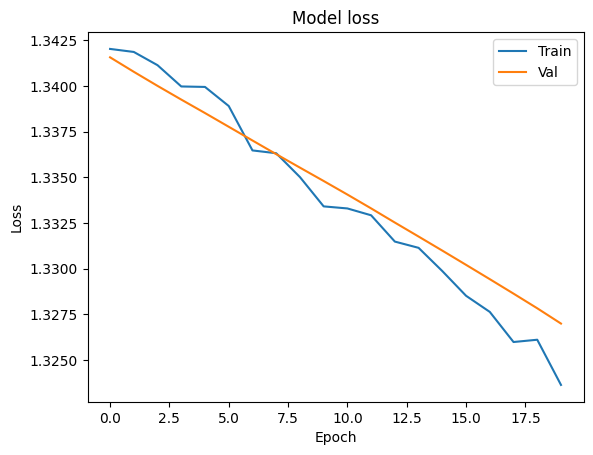

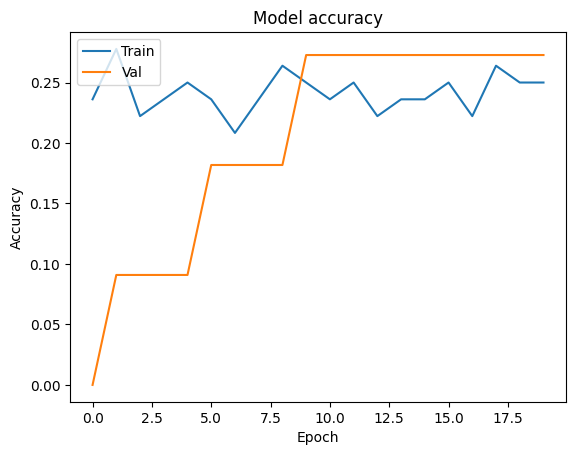

In [46]:

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

###  model saved stacked_lstm_model.h5

In [47]:
# Save the model using the TensorFlow SavedModel format
stacked_lstm_model.save('stacked_lstm_model.h5')  # Add .keras extension for the native Keras format
print("\nModel training complete and saved using SavedModel format!")

# # THIS IS HOW TO LOAD THE SAVED MODEL OF BERT

# # Load the saved model
# loaded_model = tf.keras.models.load_model('bert_text_classifier.keras')


Model training complete and saved using SavedModel format!


#=====================================

# Bidirectional LSTM Model

In [152]:
# step 1: define the bidirectional LSTM model
def create_bilstm_model(vocab_size, embedding_dim, max_seq_len, num_classes):
    model= tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size,
                                  output_dim=embedding_dim,
                                  input_length=max_seq_len),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(256, return_sequences=False)),
        # tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256,
                              activation='relu',
                              kernel_regularizer= tf.keras.regularizers.l2(0.01)),  # 0.01
        tf.keras.layers.Dropout(.4,) , # .5
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

max_seq_len= 256

# initialize the bi-LSTM model
# Assuming 'tokenizer' is BertTokenizer instance
label_encoder= LabelEncoder()
label_encoder.fit(train_data['author']) # fit on the training data

bilstm_model = create_bilstm_model(
    vocab_size=tokenizer.vocab_size,  # Use tokenizer.vocab_size instead of word_index
    embedding_dim=256,
    max_seq_len=max_seq_len,  # Make sure max_seq_len is defined
    num_classes=len(label_encoder.classes_)  # Assuming label_encoder is defined
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


- Функция create_bilstm_model: Эта функция является шаблоном для создания BiLSTM модели. Она принимает ключевые параметры, такие как vocab_size (количество уникальных слов в словаре), embedding_dim (размер словесных эмбеддингов), max_seq_len (максимальная длина входных текстовых последовательностей) и num_classes (количество категорий, на которые классифицируете).

- tf.keras.Sequential: Это указывает, что мы строим модель, в которой слои укладываются последовательно - выход одного слоя становится входом для следующего.

- tf.keras.layers.Embedding: Это первый слой, отвечающий за создание словесных эмбеддингов. Он преобразует слова в числовые векторы, которые отражают их смысл.
  - input_dim: Установлен в vocab_size.
  - output_dim: Установлен в embedding_dim, определяя размер векторов эмбеддинга.
  - input_length: Установлен в max_seq_len, указывая ожидаемую длину входных последовательностей.

- tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(...)): Это ядро BiLSTM модели.
  - Bidirectional: Этот оберточный слой заставляет LSTM обрабатывать входную последовательность как в прямом, так и в обратном направлении, захватывая контекстную информацию с обеих сторон.
  - LSTM(256, return_sequences=False): Слой LSTM с 256 единицами. return_sequences=False означает, что он выводит только конечное скрытое состояние LSTM.

- tf.keras.layers.Dense(256, activation='relu', ...): Полносвязный слой с 256 единицами и функцией активации ReLU. Он обрабатывает выходные данные слоя BiLSTM. kernel_regularizer применяет L2 регуляризацию для предотвращения переобучения.

- tf.keras.layers.Dropout(.5): Слой отсева, который случайным образом устанавливает 50% входных единиц в 0 во время обучения, дополнительно помогая предотвратить переобучение.

- tf.keras.layers.Dense(num_classes, activation='softmax'): Финальный выходной слой. Он имеет num_classes единиц и использует функцию активации softmax для создания распределения вероятностей по классам.

- return model: Функция возвращает построенную модель.

- max_seq_len = 256: Устанавливает максимальную длину последовательности в 256 токенов.
- label_encoder = LabelEncoder(): Создает объект LabelEncoder для преобразования текстовых меток (имен авторов) в числовые представления.
- label_encoder.fit(train_data['author']): Обучает LabelEncoder на именах авторов в обучающих данных, изучая уникальные метки.
- bilstm_model = create_bilstm_model(...): Здесь фактически создаете экземпляр BiLSTM модели, используя функцию create_bilstm_model.  предоставляете необходимые параметры:
  - vocab_size: Получен из размера словаря токенизатора BERT.
  - embedding_dim: Установлен в 256.
  - max_seq_len: Использует переменную max_seq_len (256).
  - num_classes: Определяется количеством уникальных меток авторов, изученных LabelEncoder.

In [153]:
# step 2: compile the model
bilstm_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), # 0.0001
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
    )

# display the model summary
bilstm_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

- bilstm_model.compile(...)
- Эта строка крайне важна, так как она настраивает модель для процесса обучения. Представьте ее как установку правил и целей для того, как модель будет учиться.
- optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001):
  - optimizer: Это определяет алгоритм, используемый для корректировки внутренних параметров модели (весов) во время обучения для минимизации ошибок. Здесь используется оптимизатор Adam, популярный выбор в глубоком обучении, известный своей эффективностью.
  - learning_rate: Этот гиперпараметр управляет размером шага, который оптимизатор делает при обновлении весов модели. Меньшая скорость обучения (например, 0.0001) может привести к более медленному, но потенциально более стабильному обучению.

- loss= tf.keras.losses.SparseCategoricalCrossentropy():
  - loss: Эта функция количественно определяет разницу между предсказаниями модели и фактическими целевыми значениями (в данном случае метками авторов). SparseCategoricalCrossentropy подходит для задач многоклассовой классификации, где целевые метки являются целыми числами (например, числовые метки авторов, которые создали ранее).
- metrics=['accuracy']:
  - metrics: Они используются для оценки производительности модели во время обучения. Здесь используется accuracy (точность), которая измеряет процент правильно классифицированных примеров.

- bilstm_model.summary()
  - Эта строка печатает краткий обзор архитектуры модели.
  - Она показывает слои, их выходные формы и количество обучаемых параметров в каждом слое. Эта сводка помогает понять структуру и сложность  модели.

### Train the Bi-LSTM model

In [154]:
# Convert author names to numerical labels using the fitted encoder
train_labels = label_encoder.transform(train_data['author'])
val_labels = label_encoder.transform(val_data['author'])

num_batch = 64

# Update train_dataset and val_dataset to include labels
train_dataset_bilstm = tf.data.Dataset.from_tensor_slices(({
    'input_ids': train_inputs['input_ids'],
    'attention_mask': train_inputs['attention_mask']
}, train_labels))  # Include labels in the dataset

val_dataset_bilstm = tf.data.Dataset.from_tensor_slices(({
    'input_ids': val_inputs['input_ids'],
    'attention_mask': val_inputs['attention_mask']
}, val_labels))  # Include labels in the dataset

# Function to extract input_ids and labels
def map_func(inputs, labels):
    return inputs['input_ids'], labels

validation_data = tf.data.Dataset.from_tensor_slices(
    ({'input_ids': val_inputs['input_ids']}, val_labels)
).map(map_func).batch(num_batch) # Apply batching to the validation set

# Use this processed 'validation_data' in the 'fit' method
# Add a try-except block to catch potential errors during training
try:
    history_bilstm = bilstm_model.fit(
        train_dataset_bilstm.map(map_func).batch(num_batch),  # Use batching for better performance
        validation_data=validation_data,  # Use the processed validation data
        epochs=20
    )
except Exception as e:
    print(f"An error occurred during training: {e}")
    # Add more debugging or error handling here if needed

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.2842 - loss: 4.7912 - val_accuracy: 0.2500 - val_loss: 4.7679
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3449 - loss: 4.7657 - val_accuracy: 0.2500 - val_loss: 4.7457
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3206 - loss: 4.7429 - val_accuracy: 0.2500 - val_loss: 4.7234
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4523 - loss: 4.7165 - val_accuracy: 0.2500 - val_loss: 4.7013
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4887 - loss: 4.6916 - val_accuracy: 0.3333 - val_loss: 4.6793
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5026 - loss: 4.6691 - val_accuracy: 0.2500 - val_loss: 4.6573
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5026 - loss: 4.6442 - val_accuracy: 0.2500 - val_loss: 4.6354
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4869 - loss: 4.6193 - val_accuracy: 0.2500 - val_loss: 4.6137
Epoch 9/20
2/2 

### Evaluate the model

In [51]:
# Step 1: Evaluate the BiLSTM model
try:
    loss, accuracy = bilstm_model.evaluate(validation_data)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
except Exception as e:
    print(f"An error occurred during evaluation: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.3636 - loss: 4.3321
An error occurred during evaluation: name 'val_loss' is not defined


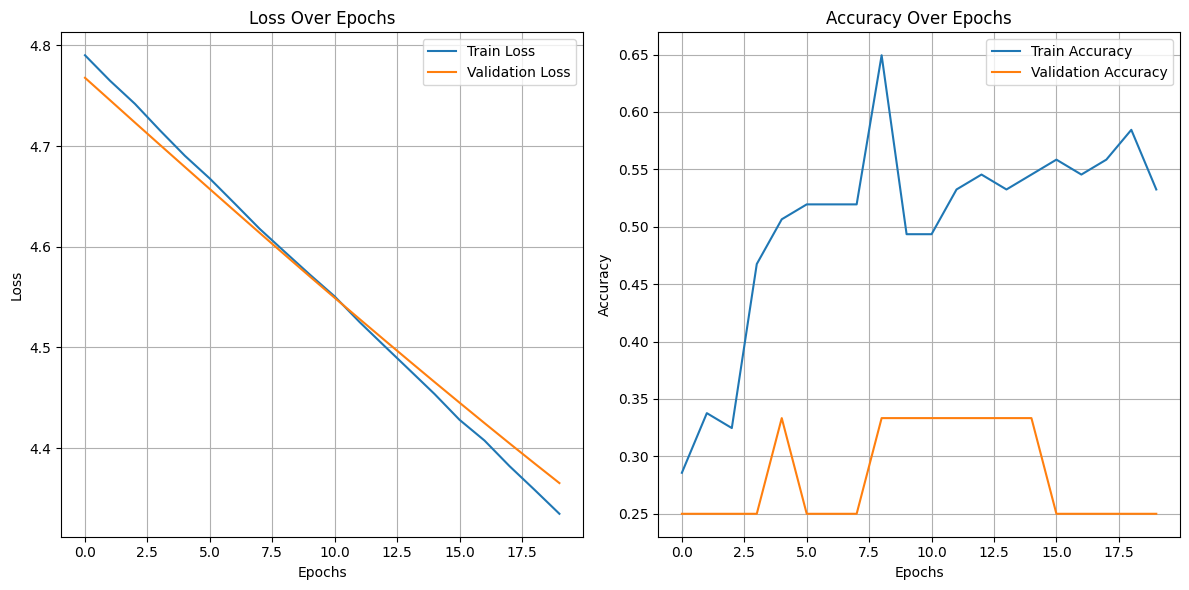

In [155]:
import matplotlib.pyplot as plt

# Step 2: Plot Training and Validation Loss
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', )
    plt.plot(history.history['val_loss'], label='Validation Loss', )
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', )
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', )
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history_bilstm)


### Model saved bilstm_model.h5

In [53]:
# Save the model using the TensorFlow SavedModel format
bilstm_model.save('bilstm_model.h5')  # Add .keras extension for the native Keras format
print("\nModel training complete and saved using SavedModel format!")

# # THIS IS HOW TO LOAD THE SAVED MODEL OF BERT

# # Load the saved model
# loaded_model = tf.keras.models.load_model('bert_text_classifier.keras')


Model training complete and saved using SavedModel format!


#========================================================================

# Predicting

In [203]:
# ==========================      BERT    ===========================
def predict_authorship_bert(model_bert, tokenizer, label_encoder, text_fragment, max_seq_len=128): # Change max_seq_len to 128 to match model input
    # Tokenisasi teks
    tokens = tokenizer(text_fragment, padding='max_length', truncation=True, max_length=max_seq_len, return_tensors="np")

    # Ambil input_ids and attention_mask
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']

    # Lakukan prediksi, passing both input_ids and attention_mask
    predictions = model_bert.predict({'input_ids': input_ids, 'attention_mask': attention_mask})

    # Ambil label dengan probabilitas tertinggi
    predicted_label = np.argmax(predictions, axis=1)

    # Konversi kembali ke nama penulis
    author_name = label_encoder.inverse_transform(predicted_label)

    return author_name[0]

# ==========================      LSTM     ===========================
def predict_authorship_lstm(stacked_lstm_model, tokenizer, label_encoder, text_fragment, max_seq_len=128): # Change max_seq_len to 128 to match model input
    # Tokenisasi teks
    tokens = tokenizer(text_fragment, padding='max_length', truncation=True, max_length=max_seq_len, return_tensors="np")

    # Ambil input_ids and attention_mask
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']

    # Lakukan prediksi, passing both input_ids and attention_mask
    predictions = stacked_lstm_model.predict({'input_ids': input_ids, 'attention_mask': attention_mask})

    # Ambil label dengan probabilitas tertinggi
    predicted_label = np.argmax(predictions, axis=1)

    # Konversi kembali ke nama penulis
    author_name = label_encoder.inverse_transform(predicted_label)

    return author_name[0]

# ==========================      Bi - LSTM    ===========================
def predict_authorship_bilstm(bilstm_model, tokenizer, label_encoder, text_fragment, max_seq_len=128): # Change max_seq_len to 128 to match model input
    # Tokenisasi teks
    tokens = tokenizer(text_fragment, padding='max_length', truncation=True, max_length=max_seq_len, return_tensors="np")

    # Ambil input_ids and attention_mask
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']

    # Lakukan prediksi, passing both input_ids and attention_mask
    predictions = bilstm_model.predict({'input_ids': input_ids, 'attention_mask': attention_mask})

    # Ambil label dengan probabilitas tertinggi
    predicted_label = np.argmax(predictions, axis=1)

    # Konversi kembali ke nama penulis
    author_name = label_encoder.inverse_transform(predicted_label)

    return author_name[0]
# Contoh penggunaan
# model = ['model_bert', 'stacked_lstm_model', 'bilstm_model']
model1 = model_bert
model2 = stacked_lstm_model
model3 = bilstm_model

# Есенин С.А.
text_fragment = "Вы помните,\nВы всё, конечно, помните,\nКак я стоял,\nПриблизившись к стене,\nВзволнованно ходили вы по комнате\nИ что-то резкое\nВ лицо бросали мне."

predicted_author1 = predict_authorship_bert(model_bert, tokenizer, label_encoder, text_fragment) # Call predict_authorship with model1
predicted_author2 = predict_authorship_lstm(stacked_lstm_model, tokenizer, label_encoder, text_fragment) # Call predict_authorship with model1
predicted_author3 = predict_authorship_bilstm(bilstm_model, tokenizer, label_encoder, text_fragment) # Call predict_authorship with model1
print(f"Model BERT Predicted author: {predicted_author1}")
print(f"Model LSTM Predicted author: {predicted_author2}")
print(f"Model Bi-LSTM Predicted author: {predicted_author3}")

# print(model[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Model BERT Predicted author: Есенин С.А.
Model LSTM Predicted author: Есенин С.А.
Model Bi-LSTM Predicted author: Некрасов Н.А.
